# Function Definition 

In [1]:
import pandas as pd
import numpy as np
import warnings, os, json
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

def load_log(log_file: str):
    with open(log_file, 'r') as file:
        lines = [x.split(' | ') for x in file.read().splitlines() if ('IbftRound' in x) or ('QbftRound' in x)]
        lines = [line for line in lines if len(line) > 1]
    result = {}
    for i in range(len(lines)):
        result[i] = lines[i]
    
    j = json.dumps(result)
    df = pd.read_json(j, orient='index')
    df.rename(columns={0: 'Timestamp',
                        1: 'Process',
                        2: 'LogLevel',
                        3: 'LogSource',
                        4: 'Description'}, inplace=True)

    df['Timestamp'] = pd.to_datetime(df.Timestamp, infer_datetime_format=True, utc=True)
    df_temp = df.loc[:, 'Description'].str.split('\. round=ConsensusRoundIdentifier', expand=True)
    df.loc[:, 'Action'] = df_temp[0].values
    df.loc[:, 'Order'] = df_temp[1].values
    df_des = df.Order.str.split('Sequence=', expand=True)[1].str.split('\, Round=', expand=True)
    df.loc[:, 'Sequence'] = df_des[0].astype(int)
    df.loc[:, 'Round'] = df_des[1].str.split('\}', expand=True)[0].astype(int)

    df.reset_index(inplace=True)
    df.drop(columns=['index', 'Description','Order'], axis=1, inplace=True)
    return df

def logs2df(logpath):
    files = [file for file in os.listdir(logpath) if 'besu' in file and '.log' in file]
    df_list = []
    for file in files:
        logfile = os.path.join(logpath, file)
        if os.stat(logfile).st_size == 0:
            continue
        df = load_log(logfile)
        node_num = int(file.split('.')[0].split('-')[1])
        df['Node'] = node_num
        df_list.append(df)
    df = pd.concat(df_list)
    df_non_empty_blksize = get_non_empty_block_df(logfile)
    df_ne_blktime = df[df.Sequence.isin(df_non_empty_blksize.BlockNum.values)]
    # df_em_blktime = df[~df.Sequence.isin(df_non_empty_blksize.BlockNum.values)]
    return df_non_empty_blksize, df_ne_blktime

def cal_time_delta(send: str, receive: str, df: pd.DataFrame) -> list:
    t_delta_ls = []
    sequences = df.Sequence.unique()
    for seq in sequences:
        df_seq = df.loc[df.Sequence == seq]
        if send in df_seq.Action.unique() and 'proposed' in send:
            c_time = pd.to_datetime(df_seq[df_seq.Action == send].Timestamp.values[0], utc=True)
            df_r = df_seq.loc[df_seq.Action == receive]
            for _, row in df_r.iterrows():
                t_delta = pd.to_datetime(row.Timestamp, utc=True) - c_time
                t_delta_ls.append(t_delta.total_seconds())
        else:
            df_send = df_seq.loc[df_seq.Action == send].sort_values('Timestamp')
            df_receive = df_seq.loc[df_seq.Action == receive].reset_index()
            sendNodes = len(df_send.Node.unique())
            receiveNodes = len(df_receive.Node.unique())
            if sendNodes == receiveNodes or sendNodes+1 == receiveNodes:
                ts = []
                for node in df_receive.Node.unique():
                    t = list(pd.to_datetime(df_receive.loc[df_receive.Node == node].Timestamp.values, utc=True))
                    ts.append(t)
                for _, row in df_send.iterrows():
                    sts = pd.to_datetime(row.Timestamp, utc=True)
                    for i in range(len(ts)):
                        if (row.Node != (i+1)) and ts[i]:
                            rts = ts[i].pop(0)
                            deltatime = (rts - sts).total_seconds()
                            t_delta_ls.append(deltatime)
    return t_delta_ls

def cal_process_time(df):
    t_process_proposal, t_process_prepare, t_process_commit = [], [], []
    sequences = df.Sequence.unique()
    for seq in sequences:
        df_seq = df.loc[df.Sequence == seq]
        for _, row in df_seq.iterrows():
            if row.Action == 'Received a proposal message':
                rts_prop = pd.to_datetime(row.Timestamp, utc=True)
                continue
            if row.Action == 'Sending prepare message':
                sts_prep = pd.to_datetime(row.Timestamp, utc=True)
                t_process_proposal.append((sts_prep - rts_prop).total_seconds())
            if row.Action == 'Received a prepare message':
                rts_prep = pd.to_datetime(row.Timestamp, utc=True)
                continue
            if row.Action == 'Sending commit message':
                sts_commit = pd.to_datetime(row.Timestamp, utc=True)
                t_process_prepare.append((sts_commit - rts_prep).total_seconds())
            if row.Action == 'Received a commit message':
                rts_commit = pd.to_datetime(row.Timestamp, utc=True)
                continue
            if row.Action == 'Importing block to chain':
                sts_import = pd.to_datetime(row.Timestamp, utc=True)
                t_process_commit.append((sts_import - rts_commit).total_seconds())
    return t_process_proposal, t_process_prepare, t_process_commit

def cal_consensus_time(df: pd.DataFrame) -> list:
    consensus_time = []
    for seq in df.Sequence.unique():
        df_seq = df.loc[(df.Sequence == seq) & ((df.Action.str.contains('block') | df.Action.str.contains('proposal')))].sort_values('Timestamp')
        ts = df_seq.Timestamp.values
        delta_t = pd.Timedelta(ts[-1] - ts[0]).total_seconds()
        consensus_time.append(delta_t)
    return consensus_time

def remove_outlier_IQR(ts):
    Q1=np.percentile(a=ts, q=25)
    Q3=np.percentile(a=ts, q=75)
    IQR = Q3 - Q1
    ts_final = [t for t in ts if t > Q1 - 1.5*IQR and t < Q3 + 1.5*IQR]
    return ts_final

def plot_hist(ts, ax=None, upper=None, bins=50, title='Frequency Histogram', xlabel='Time (ms)', ylabel='Frequency'):
    '''
    ts: time list in seconds
    upper(option): upper threshold in seconds
    bins: number of bins in histogram plot
    '''
    ax = ax or plt.gca()
    x = [1000*t for t in ts]
    if upper:
        x = [1000*t for t in ts if t>0 and t<upper]
    hist = ax.hist(x, bins=bins)
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    return hist

def get_non_empty_block_df(log_file):
    with open(log_file, 'r') as file:
        lines = [x.split(' | ') for x in file.read().splitlines() if 'QbftBesuControllerBuilder' in x]
        lines = [line for line in lines if len(line) > 1]
    result = {}
    for i in range(len(lines)):
        result[i] = lines[i]

    j = json.dumps(result)
    df = pd.read_json(j, orient='index')
    df.rename(columns={0: 'Timestamp',
                        1: 'Process',
                        2: 'LogLevel',
                        3: 'LogSource',
                        4: 'Description'}, inplace=True)

    df['Timestamp'] = pd.to_datetime(df.Timestamp, infer_datetime_format=True, utc=True)
    df_des = df.loc[:, 'Description'].str.split('/', expand=True)
    df_des.rename(columns={0: 'BlockNum',
                    1: 'BlockSize',
                    2: 'Pending',
                    3: 'Gas',
                    4: 'BlockHash'}, inplace=True)
    df_des = df_des.replace(',','', regex=True)
    df_des['BlockNum'] = df_des.BlockNum.str.split('#', expand=True)[1].astype(int)
    df_des['BlockSize'] = df_des.BlockSize.str.split('tx', expand=True)[0].astype(int)
    df_des['Pending'] = df_des.Pending.str.split('pending', expand=True)[0].astype(int)
    df_des['Gas'] = df_des.Gas.str.split('(', expand=True)[0].astype(int)
    df = df_des[(df_des.BlockSize != 0) & (df_des.BlockSize != 1)]
    return df

def cal_consensus_ts(df: pd.DataFrame) -> list:
    consensus_time = []
    for seq in df.Sequence.unique():
        df_seq = df.loc[(df.Sequence == seq) & ((df.Action.str.contains('block') | df.Action.str.contains('proposal')))].sort_values('Timestamp')
        ts = df_seq.Timestamp.values
        delta_t = pd.Timedelta(ts[-1] - ts[0]).total_seconds()
        consensus_time.append(delta_t)
    return consensus_time

def findlogs(reporttimes, logdirlist):
    logs = []
    for reporttime in reporttimes:
        for logtime in logdirlist:
            if logtime > reporttime:
                logs.append(logtime)
                break
    return logs

# Block Size Box Plot

In [12]:
netsizes = np.arange(4,38,2)
reportpaths, logpaths = [], []

logspath = '../data/logs'
logdirlist = os.listdir(logspath)
logdirlist = sorted([d.removeprefix('logs-') for d in logdirlist])

reportpaths, logpaths = {}, {}

for size in netsizes:
    reportpath = '../data/reports/{}_LB_2C7.5G_QBFT_1S'.format(size)

    reportdirs = sorted(os.listdir(reportpath))
    folders = [os.path.join(reportpath, d) for d in reportdirs]
    reportpaths[size] = folders

    logdirs = sorted(findlogs(reportdirs, logdirlist))
    folders = [os.path.join(logspath, 'logs-'+d) for d in logdirs]
    logpaths[size] = folders
logpaths

{4: ['../data/logs/logs-20220413-014843',
  '../data/logs/logs-20220413-024251',
  '../data/logs/logs-20220413-033657',
  '../data/logs/logs-20220413-043053',
  '../data/logs/logs-20220413-052503'],
 6: ['../data/logs/logs-20220413-062330',
  '../data/logs/logs-20220413-071735',
  '../data/logs/logs-20220413-081140',
  '../data/logs/logs-20220413-090556',
  '../data/logs/logs-20220413-095952'],
 8: ['../data/logs/logs-20220415-004605',
  '../data/logs/logs-20220415-014032',
  '../data/logs/logs-20220415-023453',
  '../data/logs/logs-20220415-032924',
  '../data/logs/logs-20220415-042344'],
 10: ['../data/logs/logs-20220413-105758',
  '../data/logs/logs-20220413-115205',
  '../data/logs/logs-20220413-124617',
  '../data/logs/logs-20220413-134037',
  '../data/logs/logs-20220413-143452'],
 12: ['../data/logs/logs-20220413-153336',
  '../data/logs/logs-20220413-162809',
  '../data/logs/logs-20220413-172225',
  '../data/logs/logs-20220413-181647',
  '../data/logs/logs-20220413-191122'],
 14

## Baseline

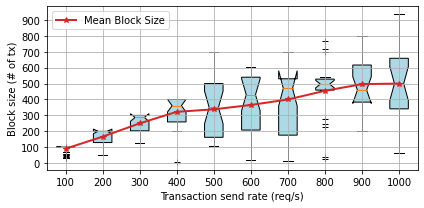

In [3]:
df = pd.read_csv('./data/df8_blksize_base.csv')
sendrates = df.SendRate.unique()
data, data_mean = [], []
for rate in sendrates:
    size = list(df[df.SendRate == rate].BlockSize)
    data.append(size)
    data_mean.append(np.mean(size))
    

fig, ax = plt.subplots(figsize=(6, 3))
X_axis = np.arange(1, len(sendrates)+1)
showfliers=True
showmeans=False
patch_artist=True

positions = np.arange(1, len(sendrates)+1)

ax.boxplot(data, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="lightblue"), zorder=1)
ax.plot(positions, data_mean, color='tab:red', label='Mean Block Size', marker='*', linewidth=2, zorder=2)
ax.grid()

ax.set_yticks(np.arange(0,1000,100))
ax.set_xlabel('Transaction send rate (req/s)')
ax.set_ylabel('Average Throughput (TPS)')

ax.set_ylabel('Block size (# of tx)')

ax.set_xticks(positions)
ax.set_xticklabels(sendrates)
ax.legend()
plt.tight_layout()
plt.show()

fig.set_size_inches(6,3)
# fig.savefig('./figs/blksize.png', dpi=300)
fig.savefig('./figs/blksize.pdf')

# total blk	383
# total tx	99432

# Consensus Time
QbftBesuControllerBuilder df1;  PersistBlockTask df2
59:30.163 - 59:30.108
calculate all none-zero block size, consensus time, import time (persist time)
1. consensus time = TS_last importing - TS_creating proposal
2. persist time = TS_imported - TS_importing
3. for proposer: TS_produced - TS_importing

## Impact of net size

In [2]:
netsizes = np.arange(4,38,2)

reportpaths, logpaths = [], []

logspath = '../data/logs'
logdirlist = os.listdir(logspath)
logdirlist = sorted([d.removeprefix('logs-') for d in logdirlist])

reportpaths, logpaths = {}, {}

for size in netsizes:
    reportpath = '../data/reports/{}_LB_2C7.5G_QBFT_1S'.format(size)

    reportdirs = sorted(os.listdir(reportpath))
    folders = [os.path.join(reportpath, d) for d in reportdirs]
    reportpaths[size] = folders

    logdirs = sorted(findlogs(reportdirs, logdirlist))
    folders = [os.path.join(logspath, 'logs-'+d) for d in logdirs]
    logpaths[size] = folders

In [22]:
# roundchange statistics
round_change = []
for size in netsizes:
    discard_num = 0
    rc_num = 0
    path = logpaths[size][0]
    logfile = os.path.join(path, 'besu-{}.log'.format(size))
    with open(logfile, 'r') as f:
        log = f.read().splitlines()
        discard_log = [ x for x in log if 'Discarding a message' in x]
        discard_num = len(discard_log)
        rc_log = [x for x in log if 'RoundChange' in x]
        rc_num = len(rc_log)
    print('{} has {} Discarding, and {} RoundChange messages.'.format(os.path.join(path, logfile), discard_num, rc_num))
    round_change.append(rc_num)

/home/ubuntu/mnt/bpet/data/logs-20220413-014843/besu-4.log has 3700 Discarding, and 0 RoundChange messages.
/home/ubuntu/mnt/bpet/data/logs-20220413-062330/besu-6.log has 7644 Discarding, and 0 RoundChange messages.
/home/ubuntu/mnt/bpet/data/logs-20220415-004605/besu-8.log has 8876 Discarding, and 0 RoundChange messages.
/home/ubuntu/mnt/bpet/data/logs-20220413-105758/besu-10.log has 24039 Discarding, and 0 RoundChange messages.
/home/ubuntu/mnt/bpet/data/logs-20220413-153336/besu-12.log has 18007 Discarding, and 0 RoundChange messages.
/home/ubuntu/mnt/bpet/data/logs-20220413-201034/besu-14.log has 15918 Discarding, and 0 RoundChange messages.
/home/ubuntu/mnt/bpet/data/logs-20220504-043906/besu-16.log has 36349 Discarding, and 0 RoundChange messages.
/home/ubuntu/mnt/bpet/data/logs-20220505-032913/besu-18.log has 30489 Discarding, and 0 RoundChange messages.
/home/ubuntu/mnt/bpet/data/logs-20220502-194521/besu-20.log has 22654 Discarding, and 2 RoundChange messages.
/home/ubuntu/mnt

In [8]:
# calculate consensus time from logs
data = []
for size in netsizes:
    consensus_time = []
    for logdir in logpaths[size]:
        # print('Calculating netsize {} for log dir {}'.format(size, logdir))
        _, df_cs = logs2df(logdir)
        cons_time = cal_consensus_ts(df_cs)
        consensus_time += cons_time
    data.append(consensus_time)

with open('./data/ct_all.json', 'w') as f:
    json.dump({'data': data}, f, indent=4) 

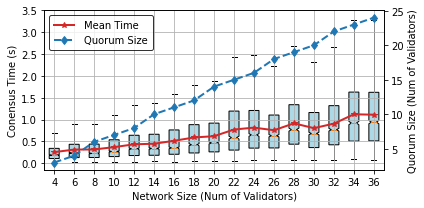

In [4]:
import math

with open('./data/ct_all.json', 'r') as f:
    data = json.load(f)['data']
    
netsizes = np.arange(4,38,2)
quorum = [math.ceil(2/3 * size) for size in netsizes]

data_mean = []
for d in data:
    data_mean.append(np.mean(d))

fig, ax = plt.subplots(figsize=(6,3))

showfliers = False
showmeans = False
patch_artist = True

X_axis = np.arange(1, len(netsizes)+1)
xlabels = netsizes
positions = X_axis

bp = ax.boxplot(data, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="lightblue"), zorder=1)

ax.plot(X_axis, data_mean, 'tab:red', marker='*', linewidth=2, label='Mean Time', zorder=2)

ax2 = ax.twinx()
ax2.set_ylabel('Quorum Size (Num of Validators)')
ax2.plot(X_axis, quorum, 'tab:blue', linestyle='--', marker='d', linewidth=2, label='Quorum Size', zorder=3)
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend((*handles1, *handles2), (*labels1, *labels2),
             loc='upper left', ncol=1, handlelength=2, edgecolor='black',
             borderpad=0.5, handletextpad=1, columnspacing=0)

ax.set_xlabel('Network Size (Num of Validators)')
ax.set_ylabel('Conensus Time (s)')
ax.set_yticks(np.arange(0,4,0.5))
ax.set_xticks(X_axis)
ax.set_xticklabels(xlabels)
# ax.legend()
ax.grid()

plt.tight_layout()
plt.show()

fig.set_size_inches(6,3)
# fig.savefig('./figs/ct_netsize.png', dpi=300)
fig.savefig('./figs/ct_netsize.pdf')

## Impact of node size

In [10]:
flavors = ['1C7.5G', '2C7.5G', '2C15G', '4C15G', '4C30G', '8C30G', '16C60G']
reportpaths, logpaths = [], []
logspath = '/home/ubuntu/mnt/bpet/data'
logdirlist = os.listdir(logspath)
logdirlist = sorted([d.removeprefix('logs-') for d in logdirlist])
reportpaths, logpaths = {}, {}

for f in flavors:
    reportpath = '../data/reports/8_LB_{}_QBFT_1S'.format(f)
    reportdirs = sorted(os.listdir(reportpath))
    folders = [os.path.join(reportpath, d) for d in reportdirs]
    reportpaths[f] = folders
    logdirs = sorted(findlogs(reportdirs, logdirlist))
    folders = [os.path.join(logspath, 'logs-'+d) for d in logdirs]
    logpaths[f] = folders

In [11]:
import subprocess
for k,v in logpaths.items():
    if k != '2C7.5G':
        for f in v:
            command = ['sudo', 'cp', '-r', f, '../data/logs/']
            # caliper_log = f.split('/')[-1]
            # command = ['sudo', 'rm', '-f', caliper_log]
            proc = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

{'1C7.5G': ['/home/ubuntu/mnt/bpet/data/logs-20220414-195408',
  '/home/ubuntu/mnt/bpet/data/logs-20220414-204938',
  '/home/ubuntu/mnt/bpet/data/logs-20220414-214516',
  '/home/ubuntu/mnt/bpet/data/logs-20220414-224056',
  '/home/ubuntu/mnt/bpet/data/logs-20220414-233632'],
 '2C7.5G': ['/home/ubuntu/mnt/bpet/data/logs-20220415-004605',
  '/home/ubuntu/mnt/bpet/data/logs-20220415-014032',
  '/home/ubuntu/mnt/bpet/data/logs-20220415-023453',
  '/home/ubuntu/mnt/bpet/data/logs-20220415-032924',
  '/home/ubuntu/mnt/bpet/data/logs-20220415-042344'],
 '2C15G': ['/home/ubuntu/mnt/bpet/data/logs-20220421-193751',
  '/home/ubuntu/mnt/bpet/data/logs-20220421-203159',
  '/home/ubuntu/mnt/bpet/data/logs-20220421-212558',
  '/home/ubuntu/mnt/bpet/data/logs-20220421-222006',
  '/home/ubuntu/mnt/bpet/data/logs-20220421-231415'],
 '4C15G': ['/home/ubuntu/mnt/bpet/data/logs-20220414-053301',
  '/home/ubuntu/mnt/bpet/data/logs-20220414-062700',
  '/home/ubuntu/mnt/bpet/data/logs-20220414-072110',
  '/h

In [5]:
def calculate_data():
    # get log paths
    flavors = ['1C7.5G', '2C7.5G', '2C15G', '4C15G', '4C30G', '8C30G', '16C60G']
    reportpaths, logpaths = [], []
    logspath = '../data/logs'
    logdirlist = os.listdir(logspath)
    logdirlist = sorted([d.removeprefix('logs-') for d in logdirlist])
    reportpaths, logpaths = {}, {}

    for f in flavors:
        reportpath = '../data/reports/8_LB_{}_QBFT_1S'.format(f)
        reportdirs = sorted(os.listdir(reportpath))
        folders = [os.path.join(reportpath, d) for d in reportdirs]
        reportpaths[f] = folders
        logdirs = sorted(findlogs(reportdirs, logdirlist))
        folders = [os.path.join(logspath, 'logs-'+d) for d in logdirs]
        logpaths[f] = folders

    # calculate consensus time from logs
    data = []
    for f in flavors:
        consensus_time = []
        for logdir in logpaths[f]:
            print('Calculating consensus time {} for log dir {}'.format(f, logdir))
            _, df_cs = logs2df(logdir)
            cons_time = cal_consensus_ts(df_cs)
            consensus_time += cons_time
        data.append(consensus_time)

In [6]:
import pickle
datafile = './data/ct_nodesize.pickle'
if not (os.path.exists(datafile)):
    print("Data file does not exist! Calculating from logs...")
    data = calculate_data()
    with open(datafile, 'wb') as f:
        pickle.dump(data, f)
else:
    print('Data file {} exists!'.format(datafile))
    with open(datafile, 'rb') as f:
        data = pickle.load(f)

Data file ./data/ct_nodesize.pickle exists!


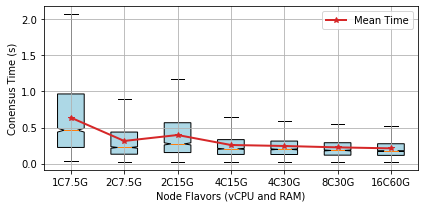

In [7]:
data_mean = []
for d in data:
    data_mean.append(np.mean(d))
flavors = ['1C7.5G', '2C7.5G', '2C15G', '4C15G', '4C30G', '8C30G', '16C60G']
fig, ax = plt.subplots(figsize=(6,3))

showfliers = False
showmeans = False
patch_artist = True

X_axis = np.arange(1, len(flavors)+1)
xlabels = flavors
positions = X_axis

# bp = ax.violinplot(data, positions=positions, showmeans=showmeans)
ax.boxplot(data, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="lightblue"), zorder=1)
ax.plot(X_axis, data_mean, 'tab:red', marker='*', linewidth=2, label='Mean Time', zorder=2)

ax.set_xlabel('Node Flavors (vCPU and RAM)')
ax.set_ylabel('Conensus Time (s)')
ax.set_xticks(X_axis)
ax.set_xticklabels(xlabels)
ax.legend()
ax.grid()

plt.tight_layout()
plt.show()

fig.set_size_inches(6,3)
# fig.savefig('./figs/consensus_time_flavor.png', dpi=300)
fig.savefig('./figs/consensus_time_flavor.pdf')